


# Objective

The objective of the notebook is to build a face detection system that can detect multiple faces.

![alt text](https://drive.google.com/uc?export=view&id=1IyzOz2M9CLM9HYod0KZNVOxdXLk4AwxR)


# Steps to solve the Face Detection problem

1. Install Dependencies
2. Loading and pre-processing the data
3. Creating annotations as per Detectron2
4. Register the dataset
5. Fine Tuning the model
6. Evaluating model performance

##1. Install Dependencies


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-3f79w2kt
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-3f79w2kt
  Resolved https://github.com/facebookresearch/detectron2.git to commit a0e22dbfa791e6235e4f196d5ce25e754d02be31
  Preparing metadata (setup.py) ... done
  Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
  Using cached fvcore-0.1.5.post20221221.t

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
detectron2: 0.6


##2. Loading and pre-processing the data

In [ ]:
# extracting files
!unzip '/content/drive/MyDrive/CV_project/Dataset/WIDER_train.zip'
!unzip '/content/drive/MyDrive/CV_project/Dataset/WIDER_val.zip'
!unzip '/content/drive/MyDrive/CV_project/Dataset/wider_face_split.zip'

Streaming output truncated to the last 5000 lines.
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_498.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_501.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_504.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_507.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_509.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_518.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_529.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_533.jpg  
  inflating: WIDER_train/images/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_spor

In [ ]:
# reading files
import pandas as pd

# specify path of the data
path_train = '/content/wider_face_split/wider_face_train_bbx_gt.txt'
path_val = '/content/wider_face_split/wider_face_val_bbx_gt.txt'

# reading data
train = pd.read_csv(path_train,header=None)
val = pd.read_csv(path_val,header=None)

In [ ]:
# first 10 rows
train.head(10)

0
0  0--Parade/0_Parade_marchingband_1_849.jpg
1                                          1
2               449 330 122 149 0 0 0 0 0 0 
3        0--Parade/0_Parade_Parade_0_904.jpg
4                                          1
5                361 98 263 339 0 0 0 0 0 0 
6  0--Parade/0_Parade_marchingband_1_799.jpg
7                                         21
8                    78 221 7 8 2 0 0 0 0 0 
9                  78 238 14 17 2 0 0 0 0 0

![alt text](https://drive.google.com/uc?export=view&id=1WN_V0rOz_vLSV6JK-oWHamUxjXUZ-0Wp)

In [ ]:
# pre-processing data
# this function accepts the dataframe and returns modified dataframe
def reformat(df):

  # fetch values of first column
  values = df[0].values

  # creating empty lists
  names=[]
  num_faces=[]
  bbox=[]

  # fetch values into corresponding lists
  for i in range(len(values)):

      # if an image
      if ".jpg" in values[i]:

        # no. of faces
        num=int(values[i+1])

        # append image name to list
        names.append(values[i])

        # append no. of faces to list
        num_faces.append(num)

        # create bbox list
        box=[]
        for j in range(i+2,i+2+num):
          box.append(values[j])

        # append bbox list to list
        bbox.append(box)

  return pd.DataFrame({'name':names,'num_faces':num_faces,'bbox':bbox})

In [ ]:
# pre-processing the data
train = reformat(train)
val = reformat(val)

In [ ]:
# first 5 rows of the pre-processed data
train.head()

name  num_faces  \
0  0--Parade/0_Parade_marchingband_1_849.jpg          1   
1        0--Parade/0_Parade_Parade_0_904.jpg          1   
2  0--Parade/0_Parade_marchingband_1_799.jpg         21   
3  0--Parade/0_Parade_marchingband_1_117.jpg          9   
4  0--Parade/0_Parade_marchingband_1_778.jpg         35   

                                                bbox  
0                     [449 330 122 149 0 0 0 0 0 0 ]  
1                      [361 98 263 339 0 0 0 0 0 0 ]  
2  [78 221 7 8 2 0 0 0 0 0 , 78 238 14 17 2 0 0 0...  
3  [69 359 50 36 1 0 0 0 0 1 , 227 382 56 43 1 0 ...  
4  [27 226 33 36 1 0 0 0 2 0 , 63 95 16 19 2 0 0 ...

In [ ]:
# shape of the training data
train.shape

(12880, 3)

In [ ]:
# adding full path
train['name'] = train['name'].apply(lambda x: 'WIDER_train/images/'+x )
val['name']   = val['name'].apply(lambda x: 'WIDER_val/images/'+x )

In [ ]:
# converting bbox to floating point
import numpy as np
train['bbox'] = train['bbox'].apply(lambda row:[ np.float_(annos.split()) for annos in row] )
val['bbox']   = val['bbox'].apply(lambda row:[ np.float_(annos.split()) for annos in row] )

In [ ]:
# extracting class names
train['class']= train['name'].apply(lambda x:x.split("/")[2].split("--")[1])
val['class']  = val['name'].apply(lambda x:x.split("/")[2].split("--")[1])

In [ ]:
# reading class names
easy_df = pd.read_csv('/content/drive/MyDrive/CV_project/Dataset/easy.txt',header=None)
easy_labels = easy_df[0].values

In [ ]:
# creating empty dataframes
train_df, val_df= pd.DataFrame(), pd.DataFrame()

# fetching rows of easy classes only
for i in easy_labels:
  train_df = pd.concat( [train_df, train[train['class']==i]] )
  val_df   = pd.concat( [val_df, val[val['class']==i]] )

In [ ]:
# shape of dataframe
train_df.shape, val_df.shape

((2307, 4), (577, 4))

In [ ]:
# first 5 rows
train_df.head()

name  num_faces  \
7983  WIDER_train/images/40--Gymnastics/40_Gymnastic...          1   
7984  WIDER_train/images/40--Gymnastics/40_Gymnastic...         15   
7985  WIDER_train/images/40--Gymnastics/40_Gymnastic...          1   
7986  WIDER_train/images/40--Gymnastics/40_Gymnastic...          9   
7987  WIDER_train/images/40--Gymnastics/40_Gymnastic...          1   

                                                   bbox       class  
7983  [[480.0, 212.0, 102.0, 120.0, 0.0, 0.0, 0.0, 0...  Gymnastics  
7984  [[971.0, 353.0, 8.0, 13.0, 2.0, 0.0, 0.0, 0.0,...  Gymnastics  
7985  [[393.0, 974.0, 112.0, 73.0, 1.0, 0.0, 0.0, 0....  Gymnastics  
7986  [[222.0, 190.0, 43.0, 52.0, 0.0, 0.0, 0.0, 0.0...  Gymnastics  
7987  [[336.0, 68.0, 236.0, 412.0, 0.0, 0.0, 0.0, 0....  Gymnastics

## 3. Creating annotations as per Detectron2

We will see how to convert the annotations of wider dataset to the annotations of Detectron2

In [ ]:
# custom annotation format
idx=0
values = train_df.values[idx]
print(values)

['WIDER_train/images/40--Gymnastics/40_Gymnastics_Gymnastics_40_785.jpg' 1
 list([array([480., 212., 102., 120.,   0.,   0.,   0.,   0.,   0.,   0.])])
 'Gymnastics']


![alt text](https://drive.google.com/uc?export=view&id=1AxlMNsub4dt7ARohSlF6mWX7fZmSVmqF)

In [ ]:
# for dealing with images
import cv2

# create annotation dict
record = {}

# image name
filename = values[0]

# height and width of an image
height, width = cv2.imread(filename).shape[:2]

# creating fields
record["file_name"] = filename
record["image_id"] = 0
record["height"] = height
record["width"] = width

In [ ]:
# different ways to represent bounding box
from detectron2.structures import BoxMode

# create bbox list
objs = []

# for every face in an image
for i in range(len(values[2])):

  # fetch bbox coordinates
  annos = values[2][i]

  # unpack values
  x1, y1, w, h = annos[0], annos[1], annos[2], annos[3]

  # compute bottom right corner
  x2, y2 = x1 + w, y1 + h

  # create bbox dict
  obj = {       "bbox": [x1, y1, x2, y2],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": 0,
                "iscrowd": 0
        }

  # append bbox dict to a bbox list
  objs.append(obj)

In [ ]:
# assign bbox list to annotation dict
record["annotations"] = objs

In [ ]:
# standard annotation format
record

{'file_name': 'WIDER_train/images/40--Gymnastics/40_Gymnastics_Gymnastics_40_785.jpg',
 'image_id': 0,
 'height': 683,
 'width': 1024,
 'annotations': [{'bbox': [480.0, 212.0, 582.0, 332.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0}]}

In [ ]:
def create_annotation(df):
  idx = 1
  # creating empty list to store annotations
  dataset_dicts = []

  # for each image
  for idx, v in enumerate(df.values):

    # create annotation dict
    record = {}

    # image name
    filename = v[0]

    # height and width of an image
    height, width = cv2.imread(filename).shape[:2]

    # assign values to fields
    record["file_name"] = filename
    record["image_id"] = idx
    record["height"] = height
    record["width"] = width

    # create bbox list
    objs = []

    # for each face in an image
    for i in range(len(v[2])):

      # bounding box coordinates
      annos = v[2][i]

      # unpack values
      x1, y1, w, h = annos[0], annos[1], annos[2], annos[3]

      # find bottom right corner
      x2, y2 = x1 + w, y1 + h

      # create bbox dict
      obj = {   "bbox": [x1, y1, x2, y2],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": 0,
                "iscrowd": 0
            }

      # append bbox dict to bbox list
      objs.append(obj)

    # assign bbox list to annotation dict
    record["annotations"] = objs

    # append annotation dict to list
    dataset_dicts.append(record)

  return dataset_dicts

In [ ]:
# create standard annotations for training and validation datasets
train_annotation = create_annotation(train_df)
val_annotation   = create_annotation(val_df)

In [ ]:
# standard annotation of an image
len(train_annotation)

2307

##4. Register the dataset

To let detectron2 know how to obtain a dataset, we will implement a function that returns the items in your dataset and then tell detectron2 about this function. For this, we will follow these steps:

1. Register your dataset (i.e., tell detectron2 how to obtain your dataset).

2. Optionally, register metadata for your dataset.

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# register dataset
DatasetCatalog.register("face_train", lambda d="train": create_annotation(train_df))

# register metadata
MetadataCatalog.get("face_train").set(thing_classes=["face"])

namespace(name='face_train', thing_classes=['face'])

In [ ]:
# for drawing bounding boxes on images
from detectron2.utils.visualizer import Visualizer

# for displaying an image
from google.colab.patches import cv2_imshow

# for randomly selecting images
import random

# get the name of the classes
face_metadata = MetadataCatalog.get("face_train")

print(face_metadata)

Metadata(name='face_train', thing_classes=['face'])


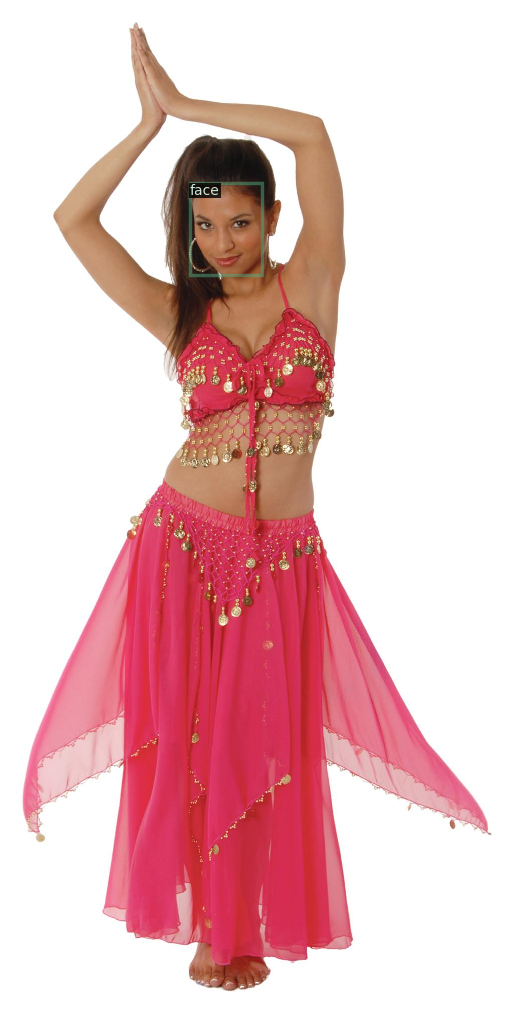

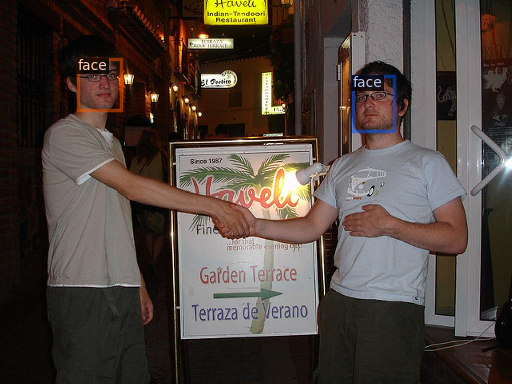

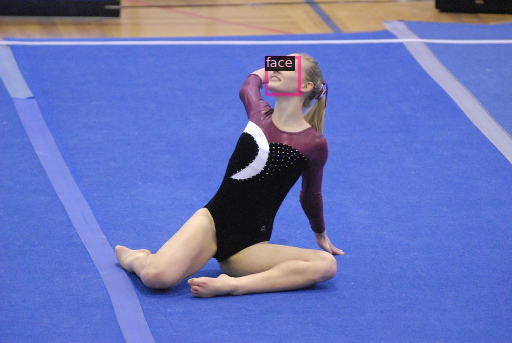

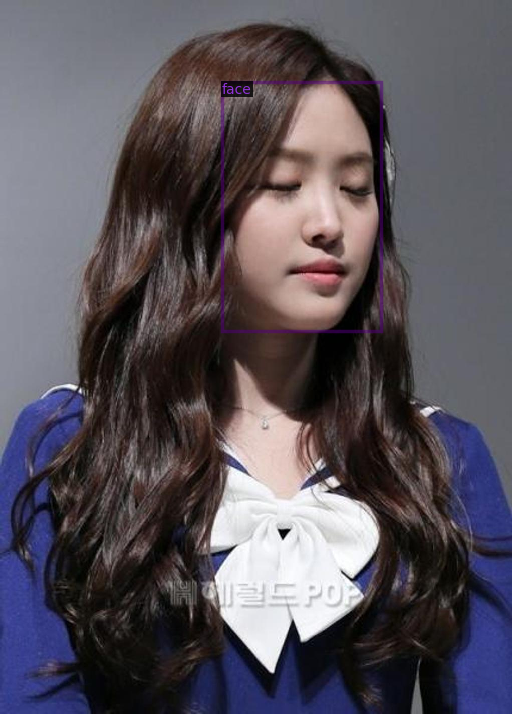

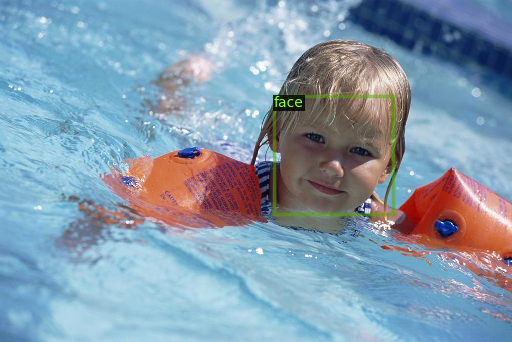

In [ ]:
# randomly select images
for d in random.sample(train_annotation, 5):

  # read an image
  img = cv2.imread(d["file_name"])

  # create visualizer
  visualizer = Visualizer(img[:, :, ::-1], metadata=face_metadata, scale=0.5)

  # draw bounding box on image
  vis = visualizer.draw_dataset_dict(d)

  # display an image
  cv2_imshow(vis.get_image()[:, :, ::-1])

## 5. Fine Tuning the model

## 1) FASTERRCNN MODEL

In [ ]:
# to obtain pretrained models
from detectron2 import model_zoo

# to train the model
from detectron2.engine import DefaultTrainer

# set up the config
from detectron2.config import get_cfg

# interact with os
import os

# define configure instance
cfg = get_cfg()

# Get a model specified by relative path under Detectron2’s official configs/ directory.
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_DC5_1x.yaml"))

# load pretrained weightsCOCO-DetectionCOCO-Detection
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_1x.yaml")

In [ ]:
# List of the dataset names for training. Must be registered in DatasetCatalog
cfg.DATASETS.TRAIN = ("face_train",)

cfg.DATASETS.TEST = ()

In [ ]:
# no. of images per batch
cfg.SOLVER.IMS_PER_BATCH = 2

#set base learning rate
cfg.SOLVER.BASE_LR = 0.001

#no. of iterations
cfg.SOLVER.MAX_ITER = 1000

# only has one class (face)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

In [ ]:
# create directory to save weights
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# create a trainer with given config
trainer = DefaultTrainer(cfg)

# If resume==True, and last checkpoint exists, resume from it, load all checkpointables (eg. optimizer and scheduler) and update iteration counter.
# Otherwise, load the model specified by the config (skip all checkpointables) and start from the first iteration.
trainer.resume_or_load(resume=False)

# train the model
trainer.train()

[12/07 18:03:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[12/07 18:03:55 d2.engine.train_loop]: Starting training from iteration 0
[12/07 18:04:15 d2.utils.events]:  eta: 0:15:37  iter: 19  total_loss: 1.147  loss_cls: 0.7335  loss_box_reg: 0.03237  loss_rpn_cls: 0.3135  loss_rpn_loc: 0.02636    time: 0.9438  last_time: 1.0669  data_time: 0.0499  last_data_time: 0.0080   lr: 1.9981e-05  max_mem: 5785M
[12/07 18:04:34 d2.utils.events]:  eta: 0:15:00  iter: 39  total_loss: 0.9057  loss_cls: 0.4923  loss_box_reg: 0.04514  loss_rpn_cls: 0.2709  loss_rpn_loc: 0.02831    time: 0.9523  last_time: 0.9443  data_time: 0.0160  last_data_time: 0.0011   lr: 3.9961e-05  max_mem: 5910M
[12/07 18:04:52 d2.utils.events]:  eta: 0:14:16  iter: 59  total_loss: 0.5559  loss_cls: 0.2275  loss_box_reg: 0.04275  loss_rpn_cls: 0.2617  loss_rpn_loc: 0.01832    time: 0.9304  last_time: 0.8601  data_time: 0.0136  last_data_time: 0.0055   lr: 5.9941e-05  max_mem: 5910M
[12/07 18:05:11 d2.utils.events]:  eta: 0:14:15  iter: 79  total_loss: 0.4604  loss_cls: 0.1431  loss_

## 6. Evaluating model

In [ ]:
# register validation dataset
DatasetCatalog.register("face_val", lambda d="val": create_annotation(val_df))

# register metadata
MetadataCatalog.get("face_val").set(thing_classes=["face"])

namespace(name='face_val', thing_classes=['face'])

In [ ]:
# load the final weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")   ## check if change in path

# set the testing threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # For Faster R-CNN

# List of the dataset names for validation. Must be registered in DatasetCatalog
cfg.DATASETS.TEST = ("face_val", )

In [ ]:
# set up predictor
from detectron2.engine import DefaultPredictor

# Create a simple end-to-end predictor with the given config that runs on single device for a single input image.
predictor = DefaultPredictor(cfg)

[12/07 18:19:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


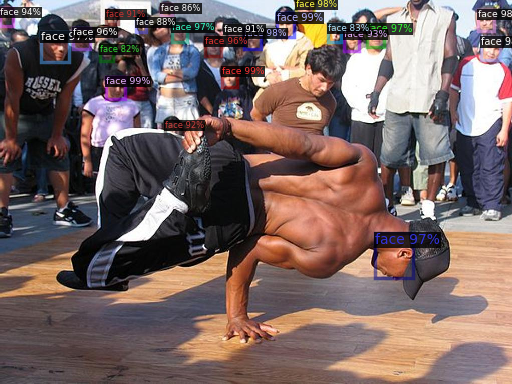

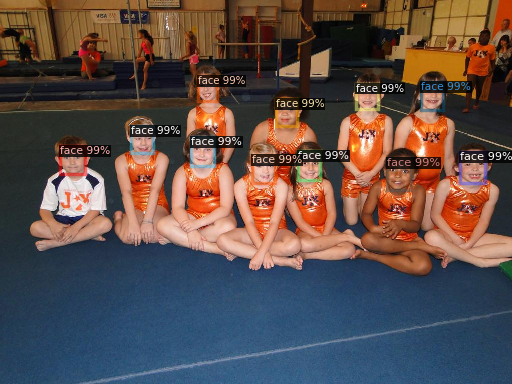

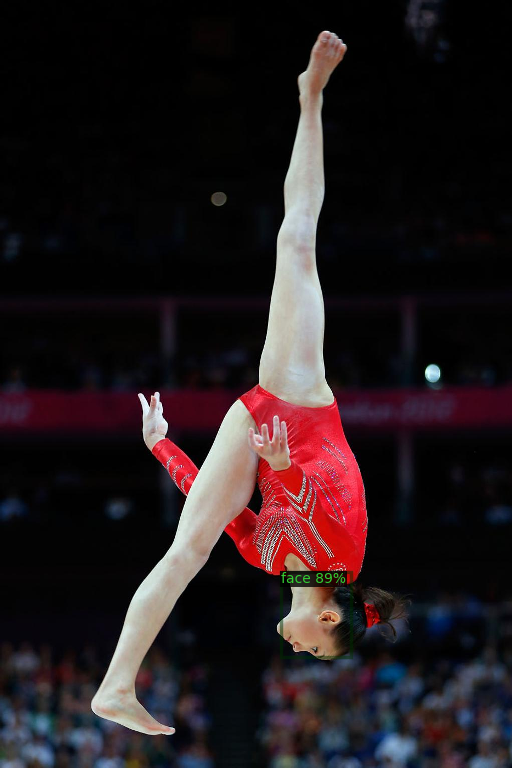

In [ ]:
# create standard annotations for validation data
dataset_dicts = create_annotation(val_df)

# randomly select images
for d in random.sample(dataset_dicts,3):

    # read an image
    im = cv2.imread(d["file_name"])

    # make predictions
    outputs = predictor(im)

    # create visualizer
    v = Visualizer(im[:, :, ::-1], metadata=face_metadata, scale=0.5)

    # draw predictions on the image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # display image
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# create a evaluator using COCO metrics
evaluator = COCOEvaluator("face_val", cfg, False, output_dir="./output/")

# create a loader for test data
val_loader = build_detection_test_loader(cfg, "face_val")

# runs the model on each image in the test data and produces the results
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [12/07 18:19:44 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/07 18:19:44 d2.evaluation.coco_evaluation]: Trying to convert 'face_val' to COCO format ...
[12/07 18:19:44 d2.data.datasets.coco]: Converting annotations of dataset 'face_val' to COCO format ...)
[12/07 18:19:50 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[12/07 18:19:51 d2.data.datasets.coco]: Conversion finished, #images: 577, #annotations: 3026
[12/07 18:19:51 d2.data.datasets.coco]: Caching COCO format annotations at './output/face_val_coco_format.json' ...
[12/07 18:19:58 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    face    | 3026         |
|            |              |
[12/07 18:19:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 8

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[12/07 18:20:02 d2.evaluation.evaluator]: Inference done 11/577. Dataloading: 0.0012 s/iter. Inference: 0.2592 s/iter. Eval: 0.0003 s/iter. Total: 0.2607 s/iter. ETA=0:02:27
[12/07 18:20:07 d2.evaluation.evaluator]: Inference done 30/577. Dataloading: 0.0032 s/iter. Inference: 0.2705 s/iter. Eval: 0.0003 s/iter. Total: 0.2742 s/iter. ETA=0:02:29
[12/07 18:20:12 d2.evaluation.evaluator]: Inference done 46/577. Dataloading: 0.0051 s/iter. Inference: 0.2843 s/iter. Eval: 0.0004 s/iter. Total: 0.2900 s/iter. ETA=0:02:33
[12/07 18:20:17 d2.evaluation.evaluator]: Inference done 65/577. Dataloading: 0.0042 s/iter. Inference: 0.2778 s/iter. Eval: 0.0003 s/iter. Total: 0.2825 s/iter. ETA=0:02:24
[12/07 18:20:23 d2.evaluation.evaluator]: Inference done 84/577. Dataloading: 0.0039 s/iter. Inference: 0.2766 s/iter. Eval: 0.0003 s/iter. Total: 0.2810 s/iter. ETA=0:02:18
[12/07 18:20:28 d2.evaluation.evaluator]: Inference done 100/577. Dataloading: 0.0046 s/iter. Inference: 0.2838 s/iter. Eval: 0.00

OrderedDict([('bbox',
              {'AP': 30.926242946447214,
               'AP50': 63.88600420907584,
               'AP75': 27.30951277114268,
               'APs': 13.389784923362145,
               'APm': 47.13239913596482,
               'APl': 48.51469389500313})])

## 2) RETINANET MODEL

In [ ]:
# to obtain pretrained models
from detectron2 import model_zoo

# to train the model
from detectron2.engine import DefaultTrainer

# set up the config
from detectron2.config import get_cfg

# interact with os
import os

# define configure instance
cfg = get_cfg()

# Get a model specified by relative path under Detectron2’s official configs/ directory.
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))

# load pretrained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")

In [ ]:
# List of the dataset names for training. Must be registered in DatasetCatalog
cfg.DATASETS.TRAIN = ("face_train",)

cfg.DATASETS.TEST = ()

In [ ]:
# no. of images per batch
cfg.SOLVER.IMS_PER_BATCH = 2

#set base learning rate
cfg.SOLVER.BASE_LR = 0.001

#no. of iterations
cfg.SOLVER.MAX_ITER = 1000

# only has one class (face)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

In [ ]:
# create directory to save weights
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# create a trainer with given config
trainer = DefaultTrainer(cfg)

# If resume==True, and last checkpoint exists, resume from it, load all checkpointables (eg. optimizer and scheduler) and update iteration counter.
# Otherwise, load the model specified by the config (skip all checkpointables) and start from the first iteration.
trainer.resume_or_load(resume=False)

# train the model
trainer.train()

[12/07 18:22:46 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
model_final_bfca0b.pkl: 152MB [00:01, 109MB/s]                           
  pixel_mean
  pixel_std


[12/07 18:23:16 d2.engine.train_loop]: Starting training from iteration 0
[12/07 18:23:36 d2.utils.events]:  eta: 0:13:03  iter: 19  total_loss: 2.697  loss_cls: 1.787  loss_box_reg: 0.8548    time: 0.9579  last_time: 0.7021  data_time: 0.0437  last_data_time: 0.0061   lr: 1.9981e-05  max_mem: 5976M
[12/07 18:23:51 d2.utils.events]:  eta: 0:11:56  iter: 39  total_loss: 2.36  loss_cls: 1.341  loss_box_reg: 0.9042    time: 0.8386  last_time: 0.7573  data_time: 0.0160  last_data_time: 0.0212   lr: 3.9961e-05  max_mem: 5976M
[12/07 18:24:05 d2.utils.events]:  eta: 0:11:24  iter: 59  total_loss: 0.8483  loss_cls: 0.4746  loss_box_reg: 0.3478    time: 0.7971  last_time: 0.6891  data_time: 0.0141  last_data_time: 0.0194   lr: 5.9941e-05  max_mem: 6024M
[12/07 18:24:20 d2.utils.events]:  eta: 0:11:03  iter: 79  total_loss: 0.9181  loss_cls: 0.4508  loss_box_reg: 0.4411    time: 0.7761  last_time: 0.7193  data_time: 0.0130  last_data_time: 0.0156   lr: 7.9921e-05  max_mem: 6024M
[12/07 18:24:34

## EVALUATING RETINANET MODEL

In [ ]:
# load the final weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# set the testing threshold for this model
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.8

# List of the dataset names for validation. Must be registered in DatasetCatalog
cfg.DATASETS.TEST = ("face_val", )

In [ ]:
# set up predictor
from detectron2.engine import DefaultPredictor

# Create a simple end-to-end predictor with the given config that runs on single device for a single input image.
predictor = DefaultPredictor(cfg)

[12/07 18:35:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


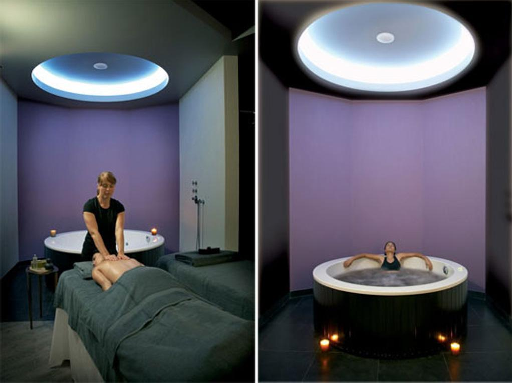

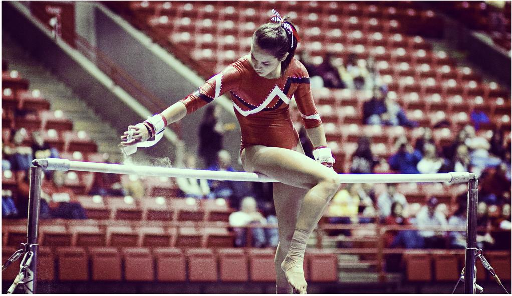

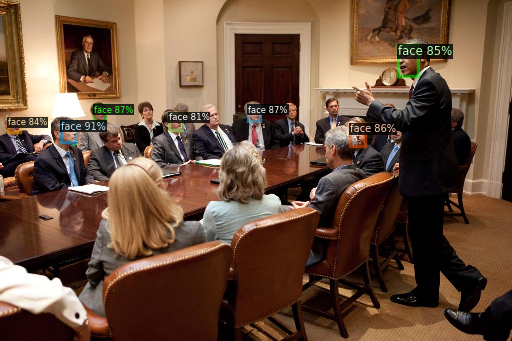

In [ ]:
# create standard annotations for validation data
dataset_dicts = create_annotation(val_df)

# randomly select images
for d in random.sample(dataset_dicts,3):

    # read an image
    im = cv2.imread(d["file_name"])

    # make predictions
    outputs = predictor(im)

    # create visualizer
    v = Visualizer(im[:, :, ::-1], metadata=face_metadata, scale=0.5)

    # draw predictions on the image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # display image
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# create a evaluator using COCO metrics
evaluator = COCOEvaluator("face_val", cfg, False, output_dir="./output/")

# create a loader for test data
val_loader = build_detection_test_loader(cfg, "face_val")

# runs the model on each image in the test data and produces the results
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [12/07 18:35:28 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/07 18:35:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/07 18:35:38 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/07 18:35:38 d2.data.common]: Serializing 577 elements to byte tensors and concatenating them all ...
[12/07 18:35:38 d2.data.common]: Serialized dataset takes 0.45 MiB
[12/07 18:35:38 d2.evaluation.evaluator]: Start inference on 577 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[12/07 18:35:41 d2.evaluation.evaluator]: Inference done 11/577. Dataloading: 0.0009 s/iter. Inference: 0.2450 s/iter. Eval: 0.0004 s/iter. Total: 0.2462 s/iter. ETA=0:02:19
[12/07 18:35:47 d2.evaluation.evaluator]: Inference done 31/577. Dataloading: 0.0026 s/iter. Inference: 0.2577 s/iter. Eval: 0.0004 s/iter. Total: 0.2608 s/iter. ETA=0:02:22
[12/07 18:35:52 d2.evaluation.evaluator]: Inference done 48/577. Dataloading: 0.0042 s/iter. Inference: 0.2698 s/iter. Eval: 0.0004 s/iter. Total: 0.2746 s/iter. ETA=0:02:25
[12/07 18:35:57 d2.evaluation.evaluator]: Inference done 69/577. Dataloading: 0.0036 s/iter. Inference: 0.2608 s/iter. Eval: 0.0004 s/iter. Total: 0.2649 s/iter. ETA=0:02:14
[12/07 18:36:02 d2.evaluation.evaluator]: Inference done 89/577. Dataloading: 0.0035 s/iter. Inference: 0.2582 s/iter. Eval: 0.0004 s/iter. Total: 0.2622 s/iter. ETA=0:02:07
[12/07 18:36:07 d2.evaluation.evaluator]: Inference done 107/577. Dataloading: 0.0042 s/iter. Inference: 0.2629 s/iter. Eval: 0.00

OrderedDict([('bbox',
              {'AP': 32.63172793888938,
               'AP50': 54.12664764148191,
               'AP75': 36.319046697652,
               'APs': 7.615904712578837,
               'APm': 56.324230032659436,
               'APl': 61.206846343276155})])